Laboratorium polegało na zapoznaniu się w praktyce z budową filtrów nakładanych na sygnał oraz ich wykorzystaniem w praktyce. 
Na wybrany plik dźwiękowy należało nałożyć filtr oraz porównać różnice poprzez zbadanie widm tych sygnałów.

Importy oraz stałe:

In [1]:
import numpy as np
import cmath
from scipy.fft import fft
from scipy.signal import firwin
from typing_extensions import Self
from os.path import exists
from typing import Optional
from matplotlib import pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram

FILTERS_DIR = './filters'

Funkcja zamieniająca podane dane z sygnału do postaci decybelowej.

In [2]:
def transform_data_to_db_scale(data: np.array) -> np.array:
    data_max = np.max(data)

    return 10 * np.log10(data / data_max)

Klasa reprezentująca filter.
Klasa zapamiętuje wyliczone za pierwszym razem właściwości, takie jak charakterystyka częstotliwościowa amplitudowa czy częstotliwości graniczne wykorzystując wzorzec lazy loader.

Opis wybranych metod:
* `calc_freq_characteristic` - oblicza charakterystyką częstotliwościową amplitudową oraz fazową dla filtru
* `calc_freq_characteristic_params` - korzysta z powyższych charakterystyk do obliczenia częstotliwości granicznych na poziomie -3dB, a na podstawie tych częstotliwości wylicza szerokość pasma
* `get_decibels_for_boundary_frequencies` - zwraca dokładne wartości decybeli dla częstotliwości granicznych

In [3]:
class Filter:
    def __init__(self, data: np.array, max_freq: int):
        self.data = data
        self.max_freq = max_freq
        self.fs = max_freq * 2

        self.amplitude_characteristic: np.array = None
        self.amplitude_characteristic_decibel: np.array = None
        self.phase_characteristic: np.array = None

        self.boundary_decibel: int = None
        self.boundary_frequencies: np.array = None
        self.bandwidth: int = None

    @property
    def shape(self) -> tuple:
        return self.data.shape

    def calc_freq_characteristic(self, force: bool = False) -> None:
        if force is False and self.amplitude_characteristic is not None and self.phase_characteristic is not None:
            return

        h_vals = []
        angle = []

        for freq in range(self.max_freq):
            omega = 2 * np.pi * freq / self.fs
            h = 0
            # h = np.sum(self.data) * np.exp(-1j * omega * np.arange(self.shape[0]))

            for fir_iter, fir_val in enumerate(self.data):
                h += fir_val * np.exp(-1j * omega * fir_iter)

            h_vals.append(h)
            angle.append(np.degrees(cmath.phase(h)))

        self.amplitude_characteristic = np.abs(h_vals)
        self.phase_characteristic = np.array(angle)

    def calc_freq_characteristic_params(self, force: bool = False) -> None:
        if force is False and self.boundary_frequencies is not None and self.bandwidth is not None:
            return

        if self.amplitude_characteristic is None:
            self.calc_freq_characteristic(True)

        self.amplitude_characteristic_decibel = transform_data_to_db_scale(self.amplitude_characteristic)
        max_decibel = np.max(self.amplitude_characteristic_decibel)

        self.boundary_frequencies = np.ones(2, dtype=int) * -1
        self.boundary_decibel = max_decibel - 3

        for freq, decibel in enumerate(self.amplitude_characteristic_decibel):
            if self.boundary_frequencies[0] == -1 and decibel > self.boundary_decibel:
                self.boundary_frequencies[0] = freq
                continue

            if self.boundary_frequencies[0] != -1 and decibel < self.boundary_decibel:
                self.boundary_frequencies[1] = freq
                break

        self.bandwidth = self.boundary_frequencies[1] - self.boundary_frequencies[0]

    def get_decibels_for_boundary_frequencies(self) -> np.array:
        if self.amplitude_characteristic_decibel is None:
            self.calc_freq_characteristic_params(True)

        return np.array([
            self.amplitude_characteristic_decibel[self.boundary_frequencies[0]],
            self.amplitude_characteristic_decibel[self.boundary_frequencies[1]],
        ])

    def get_params(self) -> dict:
        if self.boundary_frequencies is None or self.bandwidth is None:
            self.calc_freq_characteristic_params(True)

        return {
            'max_freq': self.max_freq,
            'fs': self.fs,
            'boundary_frequencies': self.boundary_frequencies,
            'bandwidth': self.bandwidth,
        }

Klasa reprezentująca sygnał.
Użyta była w laboratorium numer 1. Została rozbudowana o nowe metody.

Opis wybranych metod:
* `transform_to_db_scale` - zamienia sygnał do skali decybelowej
* `monophonize` - zwraca nową instancję tej samej klasy monofonizując sygnał o ile jest to możliwe (może już być zmonofonizowany)
* `apply_filter` - nakłada przekazany w argumencie filtr na sygnał z wykorzystaniem filtracji w dziedzinie czasu. Zwraca nową instancję sygnału z nałożonym filtrem
* `transform_to_frequency_domain` - zwraca nową instancję tej samej klasy z sygnałem przekształconym do dziedziny częstotliwości z wykorzystaniem FFT

In [4]:
class Signal:
    def __init__(self, data: np.array, samplerate: int):
        self.data: np.array = data
        self.samplerate: int = samplerate

        self.db_scale: np.array = None

    def change_samplerate(self, new_samplerate: int) -> Self:
        return Signal(
            self.__down_sample_signal(new_samplerate) if new_samplerate < self.samplerate else self.__up_sample_signal(new_samplerate),
            new_samplerate
        )

    def transform_to_db_scale(self, force: bool = False) -> np.array:
        if force is False and self.db_scale is not None:
            return self.db_scale

        self.db_scale = transform_data_to_db_scale(self.data)

        return self.db_scale

    def monophonize(self) -> Self:
        return Signal(
            self.data.sum(axis=1) / 2 if len(self.shape) > 1 and self.shape[1] > 1 else self.data,
            self.samplerate
        )

    def apply_filter(self, fir: Filter) -> Self:
        m_big = fir.shape[0]
        b = firwin(m_big, fir.boundary_frequencies, fs=self.samplerate)

        filtered_signal = np.zeros(self.shape[0])

        for n in range(m_big - 1, self.shape[0]):
            for m in range(m_big):
                filtered_signal[n] += b[m] * self.data[n - m]

        return Signal(filtered_signal, self.samplerate)

    def transform_to_frequency_domain(self) -> Self:
        return Signal(fft(self.data), self.samplerate)

    @property
    def shape(self) -> tuple:
        return self.data.shape

    @property
    def signal_length(self) -> float:
        return self.shape[0] / self.samplerate

    def __down_sample_signal(self, samplerate: int) -> np.array:
        ratio = samplerate / self.samplerate

        return self.data[np.unique(np.around(np.arange(self.shape[0]) * ratio).astype(int)), :]

    def __up_sample_signal(self, samplerate: int) -> np.array:
        ratio = samplerate / self.samplerate
        new_samples = np.full((np.round(self.shape[0] * ratio).astype(int), self.shape[1]), np.nan)

        for dim in range(self.shape[1]):
            new_samples[np.around(np.arange(self.shape[0]) * ratio).astype(int), dim] = self.data[:, dim]

            start_nan_index = -1

            for sample_iter, sample in enumerate(new_samples[:, dim]):
                if np.isnan(sample) and start_nan_index == -1:
                    start_nan_index = sample_iter
                    continue

                if not np.isnan(sample) and start_nan_index != -1:
                    mean_between_samples = np.mean([new_samples[start_nan_index - 1, dim], new_samples[sample_iter, dim]])
                    new_samples[start_nan_index - 1:sample_iter + 1] = mean_between_samples
                    start_nan_index = -1
                    continue

        return new_samples

    def get_params(self) -> dict:
        return {
            'frequency': f'{self.samplerate}Hz',
            'length': f'{self.signal_length}s',
        }

Funkcja wczytująca zaposany sygnał po filtracji pod warunkiem, że on istnieje. Jeżeli nie istnieje, zwracana jest wartość None.

In [5]:
def read_filtered_sound() -> Optional[Signal]:
    filtered_sound_filename = './hard-wagon-filtered.wav'
    if exists(filtered_sound_filename) is False:
        return None

    fs, sound_data = wavfile.read(filtered_sound_filename)
    sound_data = sound_data.astype(float)

    return Signal(sound_data, fs)

Wczytanie filtru, utworzenie instancji obiektu filtru oraz wyświetlenie parametrów filtru.

In [6]:
fir_data = np.loadtxt(f'{FILTERS_DIR}/Lab_03-Flt_01_CzM.txt')
max_freq = 20000

fir = Filter(fir_data, max_freq)
print(fir.get_params())

{'max_freq': 20000, 'fs': 40000, 'boundary_frequencies': array([ 849, 1651]), 'bandwidth': 802}


Wyświetlenie wykresów przedstawiających charakterystykę częstotliwościową amplitudową oraz fazową.

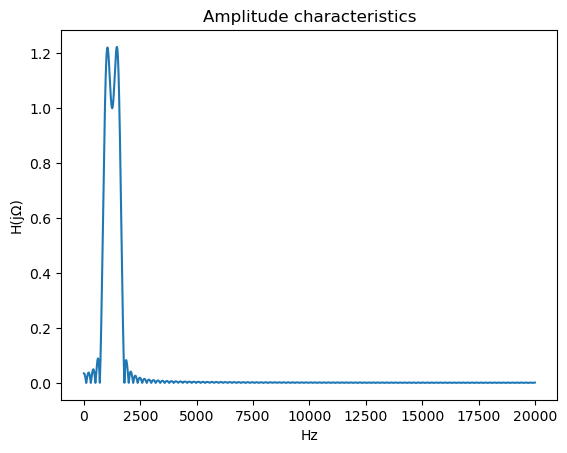

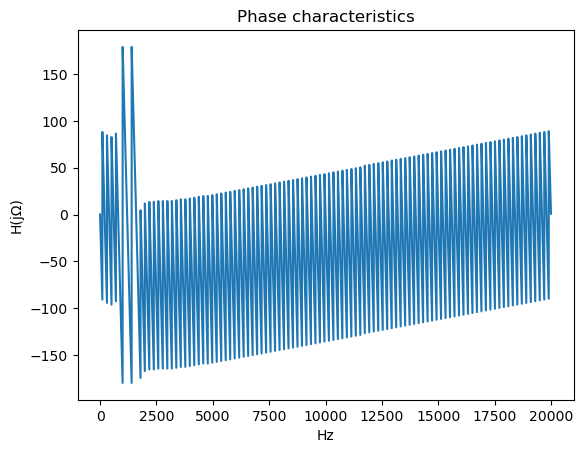

In [7]:
plt.figure()
plt.plot(np.arange(fir.max_freq), fir.amplitude_characteristic)
plt.title('Amplitude characteristics')
plt.xlabel('Hz')
plt.ylabel('H(jΩ)')
plt.show()
plt.close()

plt.figure()
plt.plot(np.arange(fir.max_freq), fir.phase_characteristic)
plt.title('Phase characteristics')
plt.xlabel('Hz')
plt.ylabel('H(jΩ)')
plt.show()
plt.close()

Wyświetlenie wykresu z zaznaczeniem częstotliwości granicznych na poziomie -3dB z wykorzystaniem charakterystyki amplitudowej.

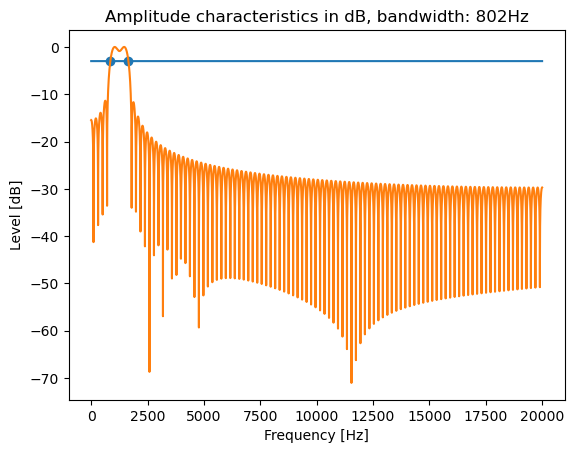

In [8]:
plt.figure()
plt.plot(np.full(fir.amplitude_characteristic_decibel.shape[0], fir.boundary_decibel))
plt.plot(np.arange(fir.max_freq), fir.amplitude_characteristic_decibel)
plt.scatter(fir.boundary_frequencies, fir.get_decibels_for_boundary_frequencies())
plt.title(f'Amplitude characteristics in dB, bandwidth: {fir.bandwidth}Hz')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Level [dB]')
plt.show()
plt.close()

Wczytanie sygnału do filtracji, utworzenie instancji obiektu sygnału, monofonizacja oraz wyświetlenie parametrów sygnału.

In [9]:
samplerate, data = wavfile.read('./HARD-WAGON.wav')
sound = Signal(data.astype(float), samplerate)
sound = sound.monophonize()
print(sound.get_params())

{'frequency': '48000Hz', 'length': '15.5935s'}


Wczytanie sygnału z nałożonym filtrem o ile istnieje. Jeżeli nie, nakładany jest filtr na wczytany sygnał, sygnał z nałożonym filtrem jest zapisywany do pliku.

In [10]:
sound_filtered = read_filtered_sound()
if sound_filtered is None:
    sound_filtered = sound.apply_filter(fir)
    wavfile.write("hard-wagon-filtered.wav", samplerate, sound_filtered.data.astype(np.int16))

Przekształcenie sygnału przed filtracją i sygnału po filtracji do dziedziny częstotliwości.

In [11]:
sound_fft = sound.transform_to_frequency_domain()
sound_filtered_fft = sound_filtered.transform_to_frequency_domain()

Wyświetlenie wykresów widm sygnałów przed filtracją i po filtracji.

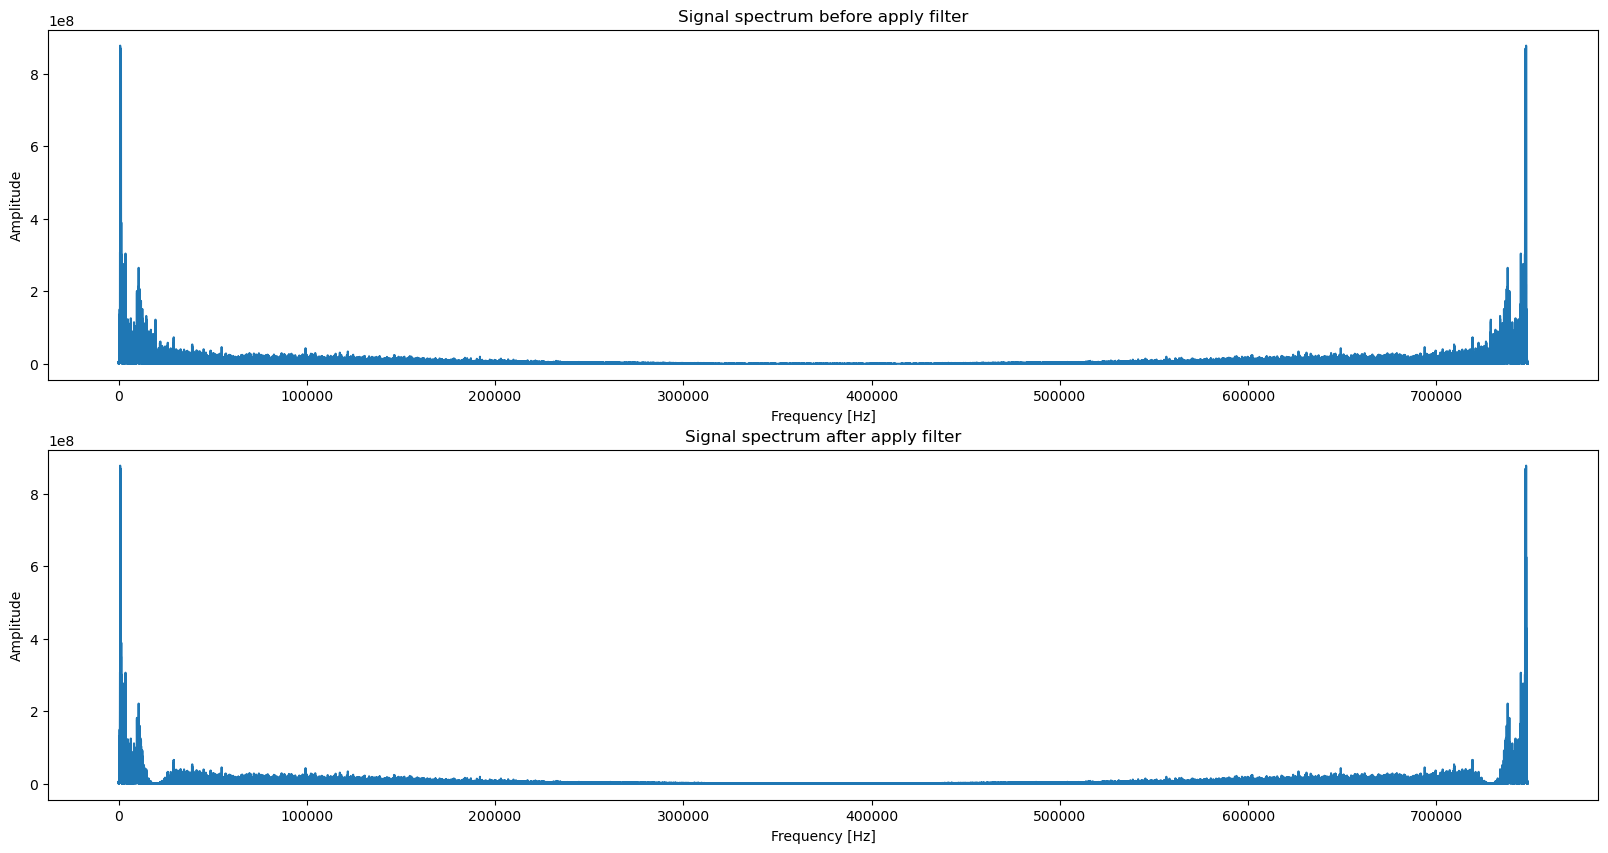

In [12]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(2, 1, 1)
ax.plot(np.abs(sound_fft.data))
ax.set_title('Signal spectrum before apply filter')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')

ax = plt.subplot(2, 1, 2)
ax.plot(np.abs(sound_filtered_fft.data))
ax.set_title('Signal spectrum after apply filter')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')

plt.show()
plt.close()

Wyświetlenie wykresów widm sygnałów przed filtracją i po filtracji z osią Y w skali logarytmicznej.

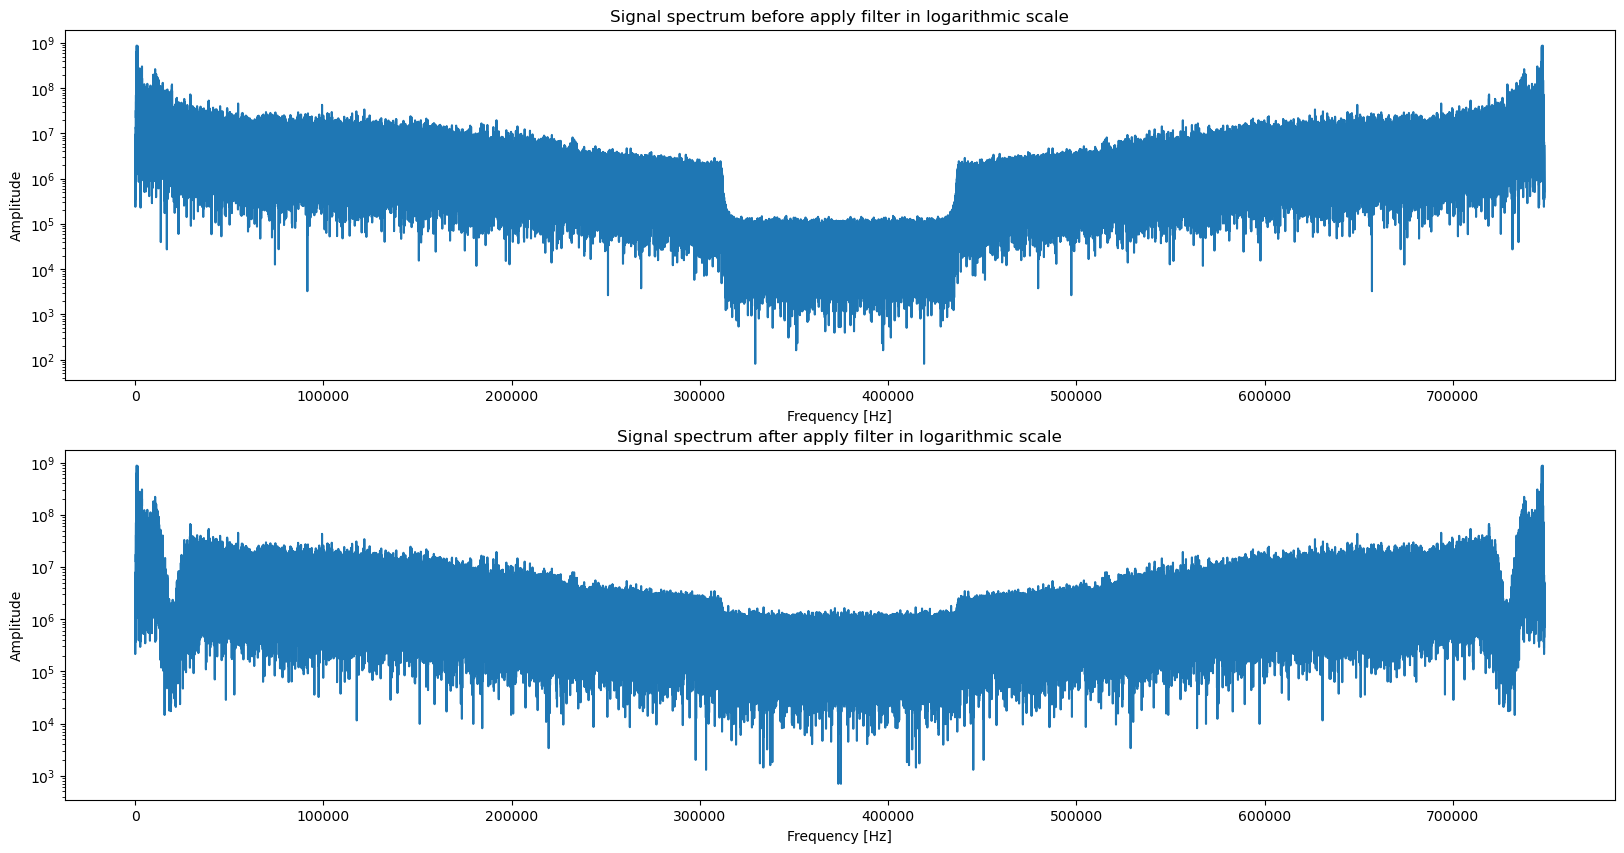

In [13]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(2, 1, 1)
ax.plot(np.abs(sound_fft.data))
ax.set_title('Signal spectrum before apply filter in logarithmic scale')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
ax.set_yscale('log')

ax = plt.subplot(2, 1, 2)
ax.plot(np.abs(sound_filtered_fft.data))
ax.set_title('Signal spectrum after apply filter in logarithmic scale')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
ax.set_yscale('log')

plt.show()
plt.close()

Wyświetlenie spektrogramów sygnałów przed filtracją i po filtracji z rozmiarem transformaty 4096.

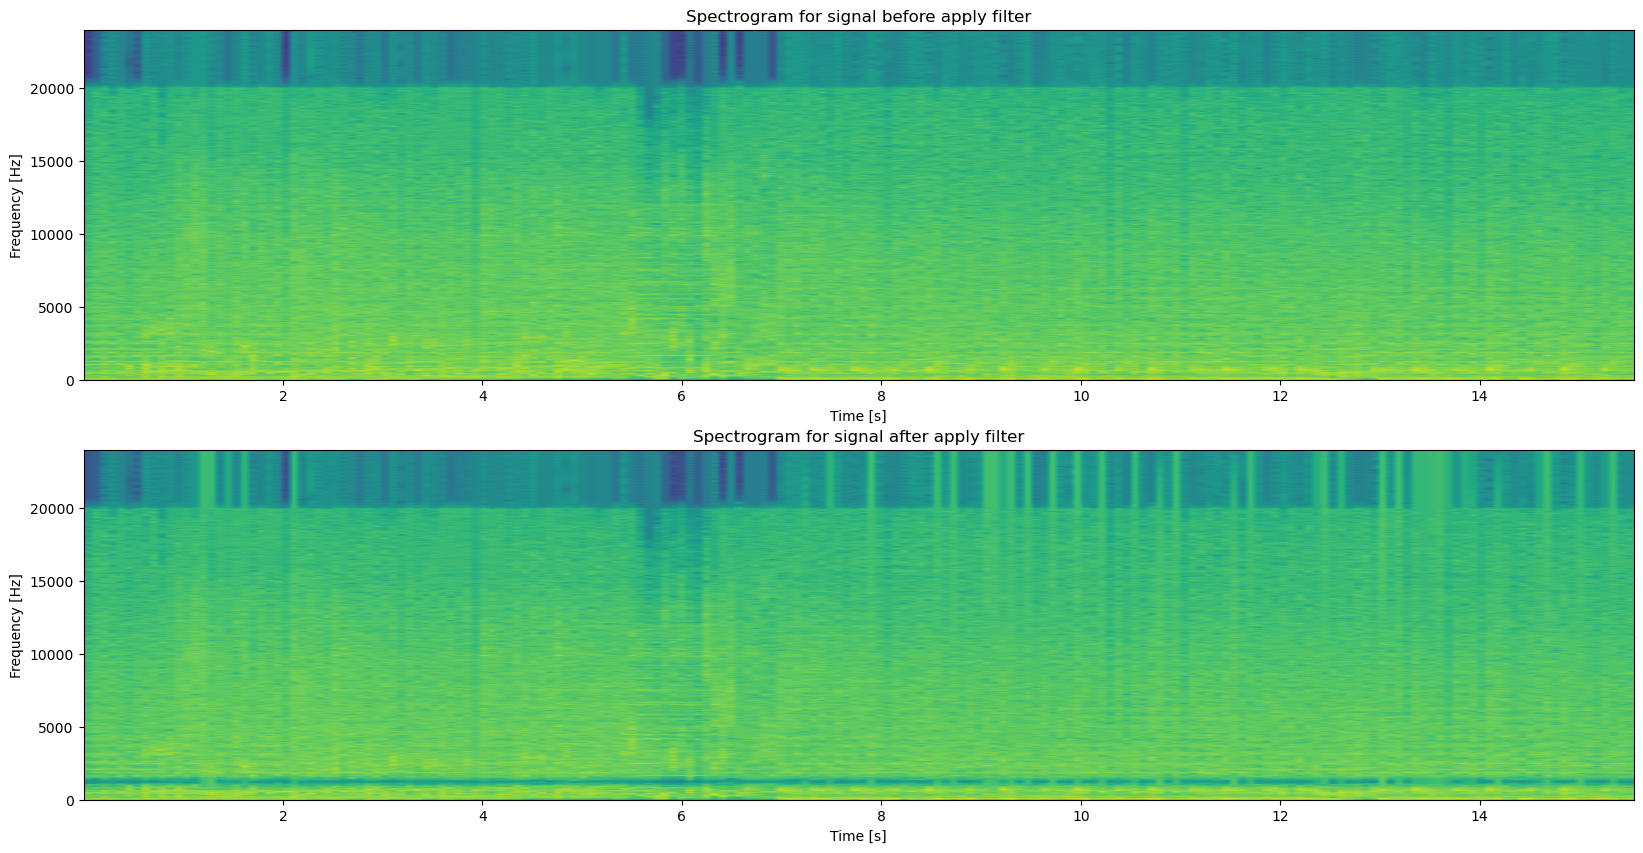

In [14]:
plt.figure(figsize=(20, 10))
ax = plt.subplot(2, 1, 1)
ax.specgram(sound.data, Fs=sound.samplerate, NFFT=4096)
ax.set_title('Spectrogram for signal before apply filter')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [Hz]')

ax = plt.subplot(2, 1, 2)
ax.specgram(sound_filtered.data, Fs=sound_filtered.samplerate, NFFT=4096)
ax.set_title('Spectrogram for signal after apply filter')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [Hz]')

plt.show()
plt.close()